<a href="https://colab.research.google.com/github/arjunjanamatti/big_mart_sales_prediction/blob/main/sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [2]:
# train data
train_df = pd.read_csv("/content/train_v9rqX0R.csv")
train_df.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


In [3]:
# test data
test_df = pd.read_csv("/content/test_AbJTz2l.csv")
test_df.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.75,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.30,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.60,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store


### EDA

#### Get information on each column: min, max, nunique, mean, median

In [4]:
def get_column_info(df: pd.DataFrame) -> pd.DataFrame:
    '''
    function to get the details about each column in dataframe
    '''
    column_info = []

    # iterate over each column of dataframe
    for col in tqdm([colu for colu in df.columns
                    if colu != 'id']):
        non_null_count = df[col].notnull().sum()
        data_type = df[col].dtype
        unique_values = df[col].nunique()
        if data_type != 'object':
            min_value = df[col].min()
            max_value = df[col].max()
            avg_value = df[col].mean()
            median_value = df[col].median()
            column_info.append({
                'column':col,
                'data_type': data_type,
                'non_null_count': non_null_count,
                'min_value':min_value,
                'max_value':max_value,
                'avg_value':round(avg_value),
                'median_value':round(median_value),
                'unique_values': unique_values
            })
        else:
            column_info.append({
                'column':col,
                'data_type': data_type,
                'non_null_count': non_null_count,
                'unique_values': unique_values
            })
    return pd.DataFrame(column_info)

In [5]:
# info about train dataframe
get_column_info(df = train_df)

100%|██████████| 12/12 [00:00<00:00, 517.91it/s]


,column,data_type,non_null_count,unique_values,min_value,max_value,avg_value,median_value
0,Item_Identifier,object,8523,1559,NaN,NaN,NaN,NaN
1,Item_Weight,float64,7060,415,4.555,21.350000,13.0,13.0
2,Item_Fat_Content,object,8523,5,NaN,NaN,NaN,NaN
3,Item_Visibility,float64,8523,7880,0.000,0.328391,0.0,0.0
4,Item_Type,object,8523,16,NaN,NaN,NaN,NaN
5,Item_MRP,float64,8523,5938,31.290,266.888400,141.0,143.0
6,Outlet_Identifier,object,8523,10,NaN,NaN,NaN,NaN
7,Outlet_Establishment_Year,int64,8523,9,1985.000,2009.000000,1998.0,1999.0
8,Outlet_Size,object,6113,3,NaN,NaN,NaN,NaN
9,Outlet_Location_Type,object,8523,3,NaN,NaN,NaN,NaN


##### Null value *columns*

* Null values are observed in two columns:
  * In 'Item_Weight' there are null values
  * In 'Outlet_Size' there are null values, this column has only 3 possible options in training data for nun null values


###### Null value analysis in "Item_Weight"

In [6]:

# Aggregation
train_df_grouped = train_df.groupby('Item_Identifier').agg({
    'Item_Weight': ['min', 'max', 'count', 'nunique', 'mean'],
    'Item_Fat_Content': ['nunique'],
    'Item_Visibility': ['nunique'],
    'Item_Type': ['nunique'],
    'Outlet_Identifier': ['nunique'],
    'Outlet_Establishment_Year': ['nunique'],
    'Outlet_Location_Type': ['nunique'],
    'Outlet_Type': ['nunique'],
})

# Flatten multi-index columns
train_df_grouped.columns = ['_'.join(col).strip() for col in train_df_grouped.columns.values]
train_df_grouped = train_df_grouped.reset_index()

# Count nulls in Item_Weight per Item_Identifier
null_counts = train_df[train_df['Item_Weight'].isnull()] \
    .groupby('Item_Identifier') \
    .size() \
    .reset_index(name='Item_Weight_null_count')

# Merge with the aggregated DataFrame
train_df_grouped = train_df_grouped.merge(null_counts, on='Item_Identifier', how='left')

# Fill NaNs in null count with 0 (for groups with no nulls)
train_df_grouped['Item_Weight_null_count'] = train_df_grouped['Item_Weight_null_count'].fillna(0).astype(int)
train_df_grouped[train_df_grouped['Item_Weight_null_count']>0]

,Item_Identifier,Item_Weight_min,Item_Weight_max,Item_Weight_count,Item_Weight_nunique,Item_Weight_mean,Item_Fat_Content_nunique,Item_Visibility_nunique,Item_Type_nunique,Outlet_Identifier_nunique,Outlet_Establishment_Year_nunique,Outlet_Location_Type_nunique,Outlet_Type_nunique,Item_Weight_null_count
1,DRA24,19.350,19.350,5,1,19.350,1,7,1,7,6,3,3,2
2,DRA59,8.270,8.270,6,1,8.270,1,8,1,8,7,3,4,2
3,DRB01,7.390,7.390,2,1,7.390,1,3,1,3,3,2,2,1
6,DRB25,12.300,12.300,5,1,12.300,1,6,1,6,6,2,4,1
7,DRB48,16.750,16.750,6,1,16.750,1,7,1,7,7,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,NCZ17,12.150,12.150,5,1,12.150,2,6,1,6,6,3,4,1
1552,NCZ18,7.825,7.825,6,1,7.825,2,7,1,7,7,3,3,1
1554,NCZ30,6.590,6.590,6,1,6.590,2,7,1,7,7,3,3,1
1557,NCZ53,9.600,9.600,4,1,9.600,1,5,1,5,5,2,4,1


In [7]:
train_df[train_df['Item_Weight'].isna()]#['Item_Identifier'].unique())
print(f"""Length of number of rows where 'Item_Weight' is null: {len(train_df[train_df['Item_Weight'].isna()])}
and number of unique 'Item_Identifiers' in these rows are: {len(train_df_grouped[train_df_grouped['Item_Weight_null_count']>0])},
and of these number of 'Item_Identifiers' which are not having any value or
have to be assumed is {len(train_df_grouped[train_df_grouped['Item_Weight_nunique']==0]['Item_Identifier'])}""")

Length of number of rows where 'Item_Weight' is null: 1463 
and number of unique 'Item_Identifiers' in these rows are: 1142, 
and of these number of 'Item_Identifiers' which are not having any value or 
have to be assumed is 4


* Hence we need to fill null values for only 4 'Item_Identifiers'

###### Handling null values in 'Item_Weight'

In [8]:
# creating a copy of training data
train_df_1 = train_df.copy()

# merge the mean values of grouped dataframe with training data
train_df_1 = train_df_1.merge(train_df_grouped[['Item_Identifier', 'Item_Weight_mean']], on='Item_Identifier', how='left')

# fill null values with weight mean
train_df_1['Item_Weight'] = train_df_1['Item_Weight'].fillna(train_df_1['Item_Weight_mean'])

# drop the mean column
train_df_1.drop('Item_Weight_mean', axis=1, inplace=True)

In [9]:
# check how many null values are left in Item_Weight
train_df_1[train_df_1['Item_Weight'].isna()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
927,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564
1922,FDK57,NaN,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280
4187,FDE52,NaN,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046
5022,FDQ60,NaN,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098


In [10]:
# for cases where item_weight is not available for Item_identifier
train_df_1[train_df_1['Item_Identifier'].isin(train_df_grouped[train_df_grouped['Item_Weight_nunique']==0]['Item_Identifier'])]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
927,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564
1922,FDK57,NaN,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280
4187,FDE52,NaN,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046
5022,FDQ60,NaN,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098


In [11]:

# Filter rows where Outlet_Establishment_Year == 1985
filtered_df = train_df_1[(train_df_1['Outlet_Establishment_Year'] == 1985)
 & ~(train_df_1['Item_Weight'].isna())].copy()

# Perform aggregation while ignoring nulls in Item_Weight
agg_result = filtered_df.groupby(['Item_Type', 'Item_Fat_Content'])['Item_Weight'].agg(
    ['mean', 'median']
)

# reset the index in the agg_result
agg_result = agg_result.reset_index()

# rename the columns
agg_result.columns = ['Item_Type', 'Item_Fat_Content', 'Item_Weight_mean', 'Item_Weight_median']

# merge agg_result dataframe with train_df_1, such that we only get Item_Weight_mean, and fill this with null values in Item_Weight
train_df_1 = train_df_1.merge(agg_result[['Item_Type', 'Item_Fat_Content', 'Item_Weight_mean']], on=['Item_Type', 'Item_Fat_Content'], how='left')
train_df_1['Item_Weight'] = train_df_1['Item_Weight'].fillna(train_df_1['Item_Weight_mean'])
train_df_1.drop('Item_Weight_mean', axis=1, inplace=True)

###### Handling null values in 'Outlet_Size'

In [12]:
# Step 1: Filter rows where 'Outlet_Size' is not null
filtered_df = train_df_1[train_df_1['Outlet_Size'].notna()].copy()

# Step 2: Define a safe mode function
def compute_mode(series):
    return series.mode().iloc[0] if not series.mode().empty else None

# Step 3: Compute mode of 'Outlet_Size' for each group
agg_result = filtered_df.groupby(['Item_Type', 'Item_Fat_Content'])['Outlet_Size'].agg(compute_mode).reset_index()
agg_result = agg_result.rename(columns={'Outlet_Size': 'Outlet_Size_mode'})

# Step 4: Merge group-level mode back to original DataFrame
train_df_1 = train_df_1.merge(agg_result, on=['Item_Type', 'Item_Fat_Content'], how='left')

# Step 5: Fill nulls in 'Outlet_Size' with group-level mode
train_df_1['Outlet_Size'] = train_df_1['Outlet_Size'].fillna(train_df_1['Outlet_Size_mode'])

# Step 6: Fill remaining nulls with overall mode
overall_mode = train_df_1['Outlet_Size'].mode().iloc[0]
train_df_1['Outlet_Size'] = train_df_1['Outlet_Size'].fillna(overall_mode)

# Step 7: Drop helper column
train_df_1.drop('Outlet_Size_mode', axis=1, inplace=True)


                           Item_Weight  Item_Visibility  Item_MRP  \
Item_Weight                   1.000000        -0.014048  0.027141   
Item_Visibility              -0.014048         1.000000 -0.001315   
Item_MRP                      0.027141        -0.001315  1.000000   
Outlet_Establishment_Year    -0.011588        -0.074834  0.005020   
Item_Outlet_Sales             0.014123        -0.128625  0.567574   

                           Outlet_Establishment_Year  Item_Outlet_Sales  
Item_Weight                                -0.011588           0.014123  
Item_Visibility                            -0.074834          -0.128625  
Item_MRP                                    0.005020           0.567574  
Outlet_Establishment_Year                   1.000000          -0.049135  
Item_Outlet_Sales                          -0.049135           1.000000  


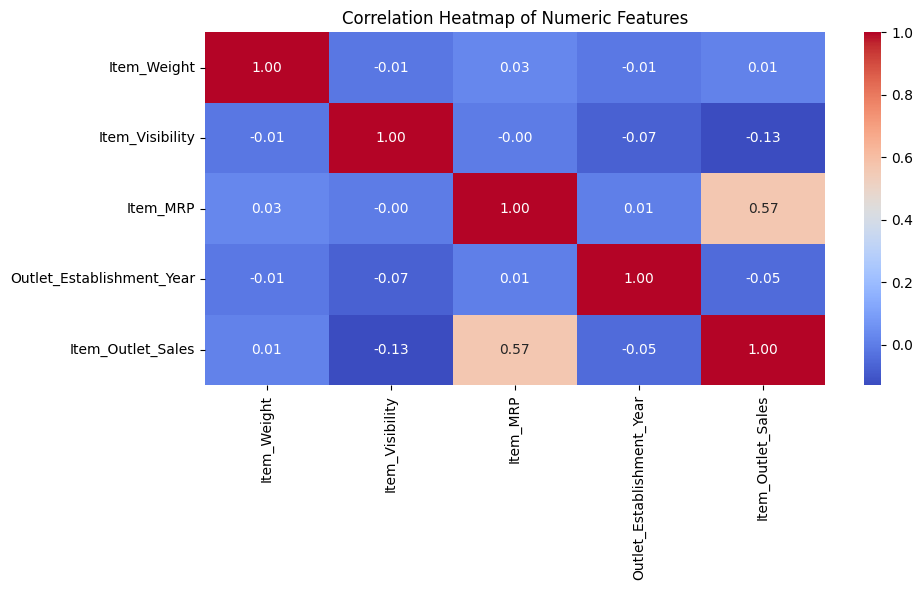

In [13]:


# Select only numeric columns (excluding object types)
numeric_df = train_df.select_dtypes(exclude=['object'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()
print(corr_matrix)

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()


* Based on the above correlation matrix, there is high correlation between Item_MRP and Item_Outlet_Sales

##### Columns identification and Feature engineering
* The Encoding depends on the type of object column, if it is ordinal(have meaningful orders) or cardinal (have no meaningful orders)
* Item_Fat_Content, Outlet_Size, Outlet_Location_Type are of "Ordinal" type
* Item_Type, Outlet_Identifier, Outlet_Type are of "Cardinal" type

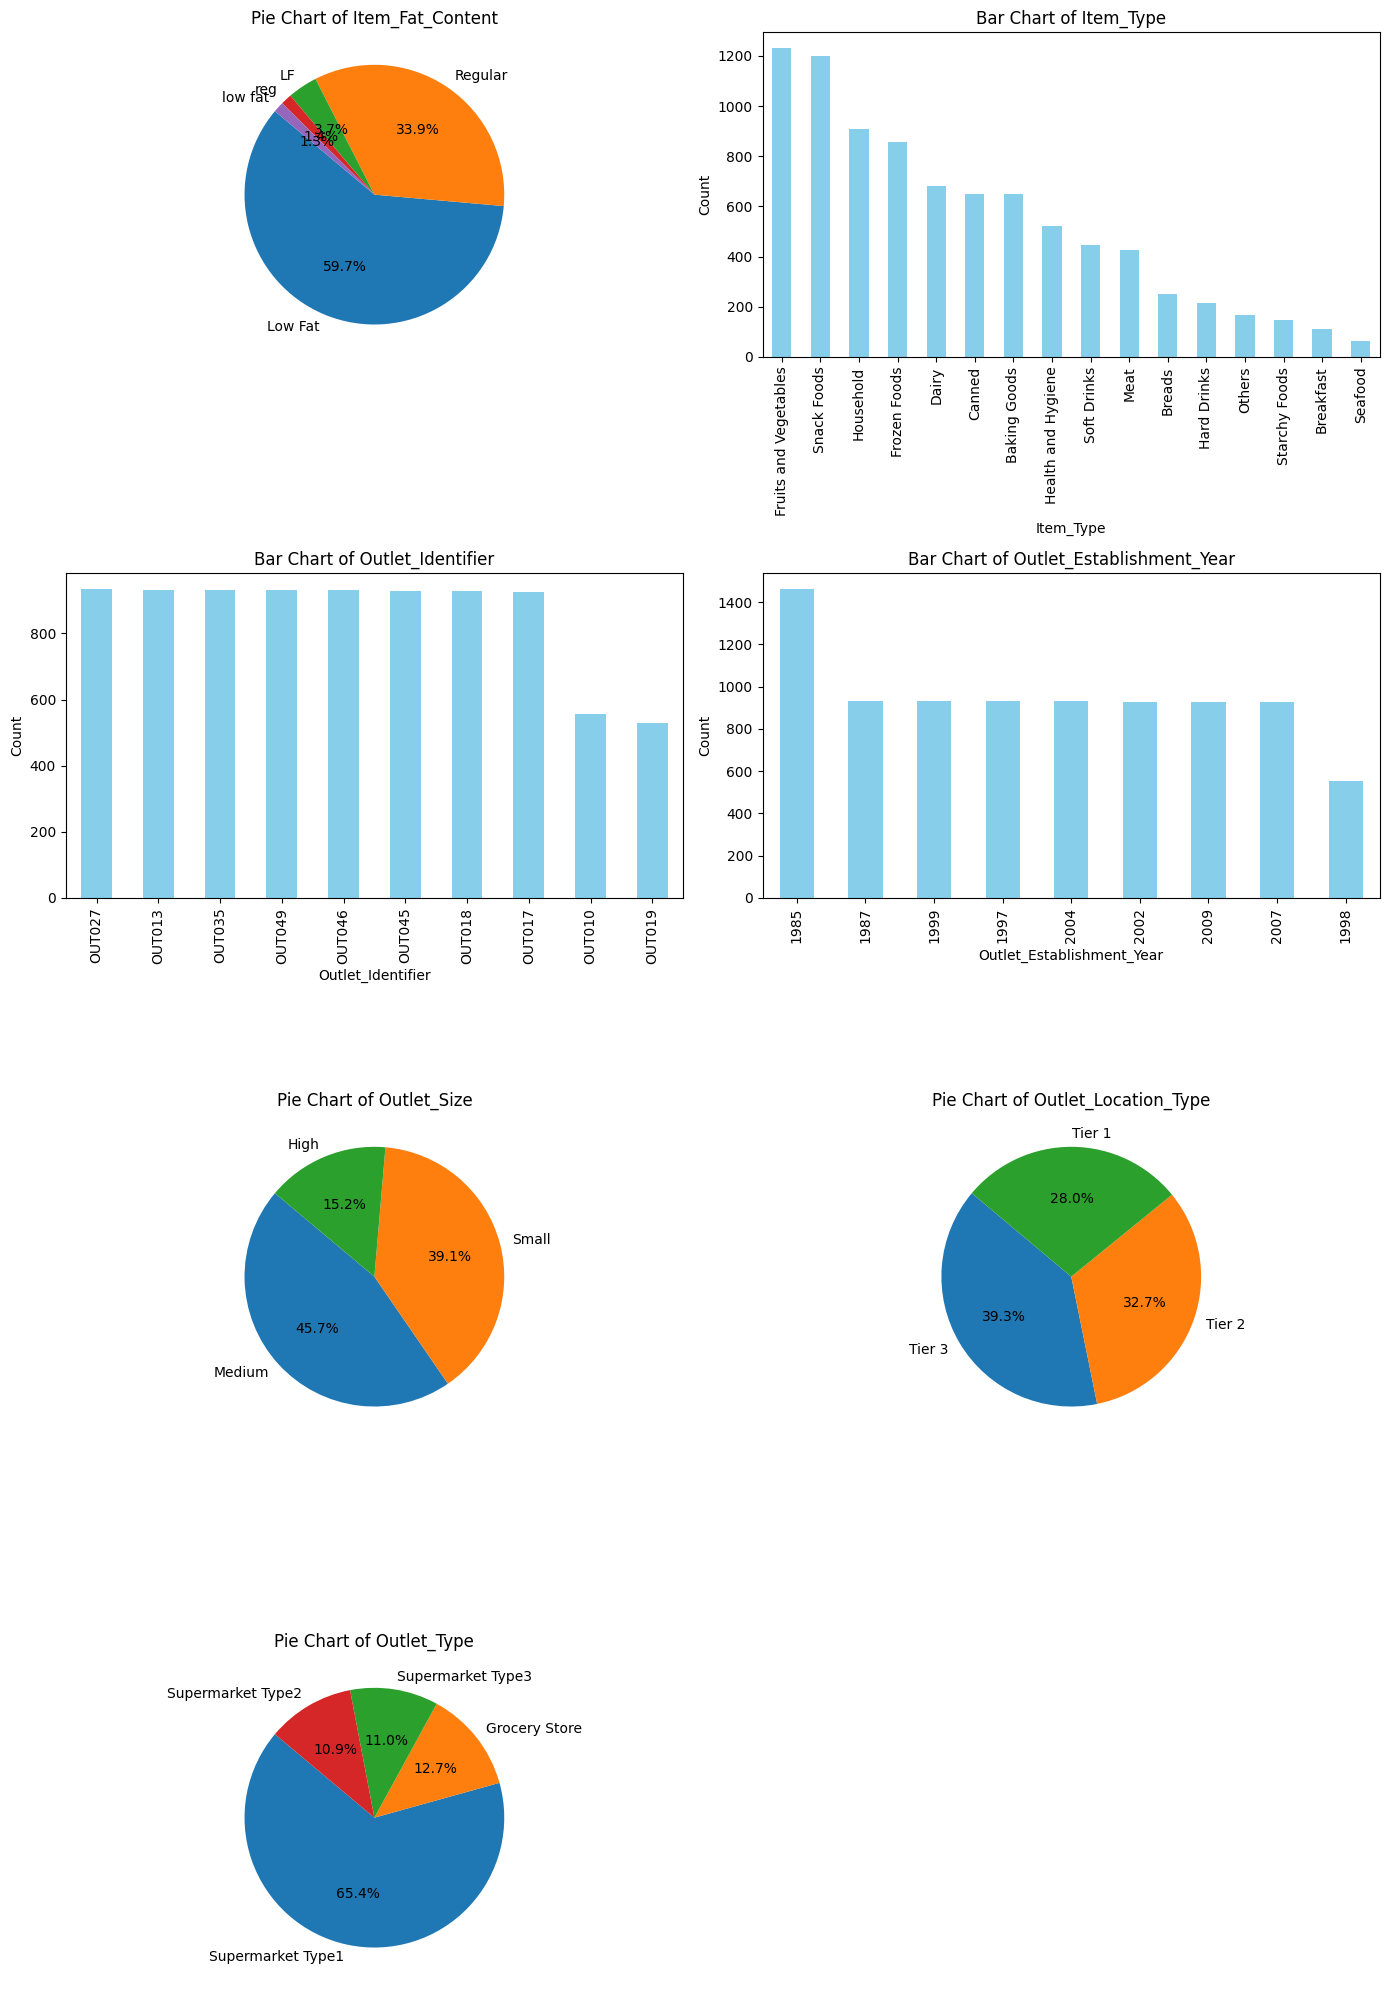

In [14]:

# Identify columns with < 20 unique values
columns_to_plot = [col for col in train_df.columns if train_df[col].nunique() < 20]

# Plot two charts per row
num_cols = 2
num_rows = (len(columns_to_plot) + 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 5 * num_rows))

for idx, col in enumerate(columns_to_plot):
    row, col_idx = divmod(idx, num_cols)
    ax = axes[row, col_idx] if num_rows > 1 else axes[col_idx]
    counts = train_df[col].value_counts()
    if train_df[col].nunique() <= 5:
        ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
        ax.set_title(f'Pie Chart of {col}')
    else:
        counts.plot(kind='bar', color='skyblue', ax=ax)
        ax.set_title(f'Bar Chart of {col}')
        ax.set_ylabel('Count')
        ax.set_xticklabels(counts.index, rotation=90)

# Hide any unused subplot
if len(columns_to_plot) % 2 != 0:
    axes[-1, -1].axis('off')

plt.tight_layout()
plt.show()


* Correction of Item_Fat_Content, since there is discrepency there

In [15]:
# # Mapping inconsistent labels to standard categories
# fat_content_mapping = {
#     'Low Fat': 'Low Fat',
#     'LF': 'Low Fat',
#     'low fat': 'Low Fat',
#     'Regular': 'Regular',
#     'reg': 'Regular'
# }

# # Apply the mapping
# train_df_1['Item_Fat_Content'] = train_df_1['Item_Fat_Content'].replace(fat_content_mapping)

# # Optional: check the result
# print(train_df_1['Item_Fat_Content'].value_counts())


# Clean inconsistent labels in Item_Fat_Content
def clean_item_fat_content(df):
    mapping = {
        'Low Fat': 'Low Fat',
        'LF': 'Low Fat',
        'low fat': 'Low Fat',
        'Regular': 'Regular',
        'reg': 'Regular'
    }
    df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(mapping)
    return df

clean_item_fat_content(train_df_1)

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64


In [16]:
# Step 2: Classify columns
column_classification = {
    'Item_Identifier': 'cardinal',
    'Item_Weight': 'continuous',
    'Item_Fat_Content': 'ordinal',
    'Item_Visibility': 'continuous',
    'Item_Type': 'cardinal',
    'Item_MRP': 'continuous',
    'Outlet_Identifier': 'cardinal',
    'Outlet_Establishment_Year': 'discrete',
    'Outlet_Size': 'ordinal',
    'Outlet_Location_Type': 'ordinal',
    'Outlet_Type': 'cardinal',
    'Item_Outlet_Sales': 'continuous'
}

# Step 3: Label encode ordinal columns
ordinal_cols = [col for col, typ in column_classification.items() if typ == 'ordinal']
for col in ordinal_cols:
    train_df_1[col] = LabelEncoder().fit_transform(train_df_1[col].astype(str))

# Step 4: One-hot encode cardinal columns
cardinal_cols = [col for col, typ in column_classification.items() if typ == 'cardinal']
train_df_2 = pd.get_dummies(train_df_1, columns=cardinal_cols)

# Step 5: Output summary
print("Column Classification:")
for col, typ in column_classification.items():
    print(f"{col}: {typ}")

print("\nProcessed DataFrame shape:", train_df_2.shape)
print(train_df_2.head(3))


Column Classification:
Item_Identifier: cardinal
Item_Weight: continuous
Item_Fat_Content: ordinal
Item_Visibility: continuous
Item_Type: cardinal
Item_MRP: continuous
Outlet_Identifier: cardinal
Outlet_Establishment_Year: discrete
Outlet_Size: ordinal
Outlet_Location_Type: ordinal
Outlet_Type: cardinal
Item_Outlet_Sales: continuous

Processed DataFrame shape: (8523, 1597)
   Item_Weight  Item_Fat_Content  Item_Visibility  Item_MRP  \
0         9.30                 0         0.016047  249.8092   
1         5.92                 1         0.019278   48.2692   
2        17.50                 0         0.016760  141.6180   

   Outlet_Establishment_Year  Outlet_Size  Outlet_Location_Type  \
0                       1999            1                     0   
1                       2009            1                     2   
2                       1999            1                     0   

   Item_Outlet_Sales  Item_Identifier_DRA12  Item_Identifier_DRA24  ...  \
0          3735.1380       

### Model Training

In [20]:

# Step 6: Prepare features and target
X = train_df_2.drop('Item_Outlet_Sales', axis=1)
y = train_df_2['Item_Outlet_Sales']

# Step 7: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model and parameter grid
model = XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Randomized search
search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10,
                            scoring='neg_root_mean_squared_error', cv=3, verbose=1, n_jobs=-1)
search.fit(X_train, y_train)

# Best model evaluation
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", search.best_params_)
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 